## Setup env and jupyter kernel

In [1]:
!uv run $DATA_ROOT/ml-lab/setup_kernel.py diffusers-lab

Using CPython 3.13.11
Creating virtual environment at: .venv
Resolved 152 packages in 2ms
Prepared 1 package in 11ms                                               
Installed 123 packages in 251ms1.0a20260118                 
 + accelerate==1.13.0.dev0 (from git+https://github.com/huggingface/accelerate@38dadd9537d3cb43e3149964c06a3f011b40aa6d)
 + anyio==4.12.1
 + argon2-cffi==25.1.0
 + argon2-cffi-bindings==25.1.0
 + arrow==1.4.0
 + asttokens==3.0.1
 + async-lru==2.1.0
 + attrs==25.4.0
 + babel==2.17.0
 + beautifulsoup4==4.14.3
 + bleach==6.3.0
 + certifi==2022.12.7
 + cffi==2.0.0
 + charset-normalizer==2.1.1
 + click==8.3.1
 + comm==0.2.3
 + compel==2.3.1
 + debugpy==1.8.19
 + decorator==5.2.1
 + defusedxml==0.7.1
 + diffusers==0.37.0.dev0 (from git+https://github.com/huggingface/diffusers@ec376293714f269947f6d9d8a572bd73040bc1a0)
 + diffusers-lab==0.1.0 (from file:///work/ml-lab/diffusers-lab)
 + executing==2.2.1
 + fastjsonschema==2.21.2
 + filelock==3.19.1
 + fqdn==1.5.1
 + fsspec=

## SDXL

#### Initial setup

In [2]:
import os
from IPython.display import display
import torch
from diffusers import StableDiffusionXLPipeline

# Disable MIOpen on gfx1151
if os.environ.get("RUNTIME_TYPE", "") == "rocm-gfx1151":
    torch.backends.cudnn.enabled = False

work_dir = os.environ.get('DATA_ROOT', '/work')
%cd {work_dir}
%load_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv

/work


### Load models

In [3]:
model = "checkpoints/JANKUTrainedNoobaiRouwei_v60.safetensors"
model_path = f"{work_dir}/models/{model}"

pipeline = StableDiffusionXLPipeline.from_single_file(
    model_path,
    use_safetensors=True,
    disable_mmap=True,
    )
pipeline = pipeline.to("cuda", dtype=torch.float16)
last_seed = 4552815869463591

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

### Main Pipeline

#### T2I

('masterpiece, best quality, amazing quality, 4k, very aesthetic, high resolution, ultra-detailed, absurdres, newest, scenery, 1girl, solo, full body, standing, straight on, clothed, safe, looking at viewer, smiling, hatsune miku, white shirt, short sleeves, white skirt, pleated skirt, white thighhighs, outdoors, cloud, sky, daytime, wild, grass, lake, black shoes, BREAK, depth of field',
 '1girl, solo, full body, standing, straight on, clothed, safe, looking at viewer, smiling, hatsune miku, white shirt, short sleeves, white skirt, pleated skirt, white thighhighs, outdoors, cloud, sky, daytime, wild, grass, lake, black shoes, monochrome, modern, recent, old, oldest, cartoon, graphic, text, painting, crayon, graphite, abstract, glitch, deformed, mutated, ugly, disfigured, long body, lowres, bad anatomy, (bad hands, missing fingers, extra fingers, extra digits, fewer digits:1.2), cropped, very displeasing, (worst quality, bad quality:1.2), sketch, jpeg artifacts, signature, watermark, u

Seed: 2573968704570331


  0%|          | 0/20 [00:00<?, ?it/s]

/work/ml-lab/diffusers-lab/.venv/lib/python3.13/site-packages/diffusers/pipelines/stable_diffusion_xl/pipeline_stable_diffusion_xl.py:748: FutureWarning: `upcast_vae` is deprecated and will be removed in version 1.0.0. `upcast_vae` is deprecated. Please use `pipe.vae.to(torch.float32)`. For more details, please refer to: https://github.com/huggingface/diffusers/pull/12619#issue-3606633695.
  deprecate(


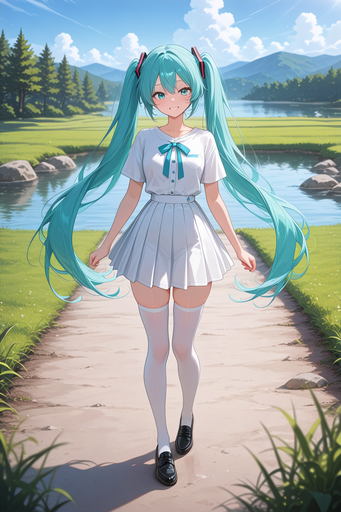

In [36]:
from diffusers import EulerAncestralDiscreteScheduler
from diffusers_lab.prompting import get_il_prompts 
from diffusers_lab.conditioning import get_sdxl_prompt_embeds
from diffusers_lab import preview_image
from typing import Any
from PIL import Image

def run_t2i():
    global pos, neg, pipeline, generator, last_seed, image
    pos, _, neg, _ = get_il_prompts("""
    1girl, solo,
    full body, standing,
    straight on,
    clothed, safe,
    looking at viewer, smiling,
    hatsune miku,
    white shirt, short sleeves
    white skirt, pleated skirt, white thighhighs
    outdoors, cloud, sky, daytime, wild, grass, lake
    black shoes
    """, reality=False)
    _ = display((pos, neg))

    prompt_embeds = get_sdxl_prompt_embeds(pipeline, pos, neg)

    pipeline.scheduler = EulerAncestralDiscreteScheduler.from_config(
        pipeline.scheduler.config,
        use_beta_sigmas = True,
        timestep_spacing = "linspace"
        )
    generator = torch.Generator(device="cuda").manual_seed(last_seed)
    last_seed = generator.seed() # uncomment to randomize
    print(f"Seed: {last_seed}")
    params: dict[str, Any] = dict(
        num_inference_steps = 20,
        guidance_scale = 2.5,
        width = 1024,
        height = 1536
    )
    params.update(prompt_embeds)
    params["generator"] = generator

    image = pipeline(**params)[0][0] # pyright: ignore[reportOptionalSubscript, reportIndexIssue]
    assert isinstance(image, Image.Image)

run_t2i()
preview_image(image) # pyright: ignore[reportArgumentType]


#### Face Detailer

Detailer: Segmenting using prompt 'face, eyes'
Detailer: Segmented 0.76611328125 @ [456.5, 220.5, 576.5, 350.5]
Detailer: Segmented 1 masks
Detailer: Merging all masks


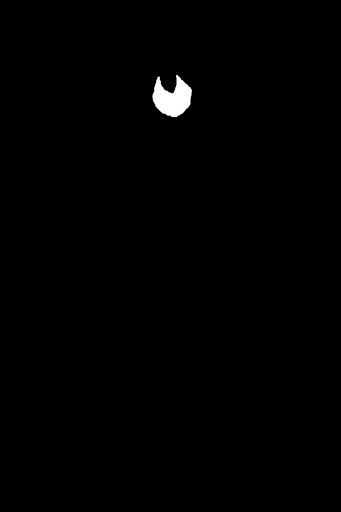

Detailer: Processing mask with bbox [457.0, 224.0, 575.0, 350.0]
Detailer: Expanded context bbox to (428, 193, 604, 381)
Detailer: Force ratio 1, final bbox: (428, 199, 604, 375)
Detailer: Upscaled dimension: (1024, 1024)
Detailer: 64-div Crop: (0, 0, 1024, 1024), size: 
Detailer: Diffusion dimensions: (1024, 1024)
Detailer: Final patch bbox: (428, 199, 604, 375)


  0%|          | 0/8 [00:00<?, ?it/s]

/work/ml-lab/diffusers-lab/.venv/lib/python3.13/site-packages/diffusers/pipelines/stable_diffusion_xl/pipeline_stable_diffusion_xl_inpaint.py:1001: FutureWarning: `upcast_vae` is deprecated and will be removed in version 1.0.0. `upcast_vae` is deprecated. Please use `pipe.vae.to(torch.float32)`. For more details, please refer to: https://github.com/huggingface/diffusers/pull/12619#issue-3606633695.
  deprecate(


Detailer: Finished mask with bbox (428, 199, 604, 375)


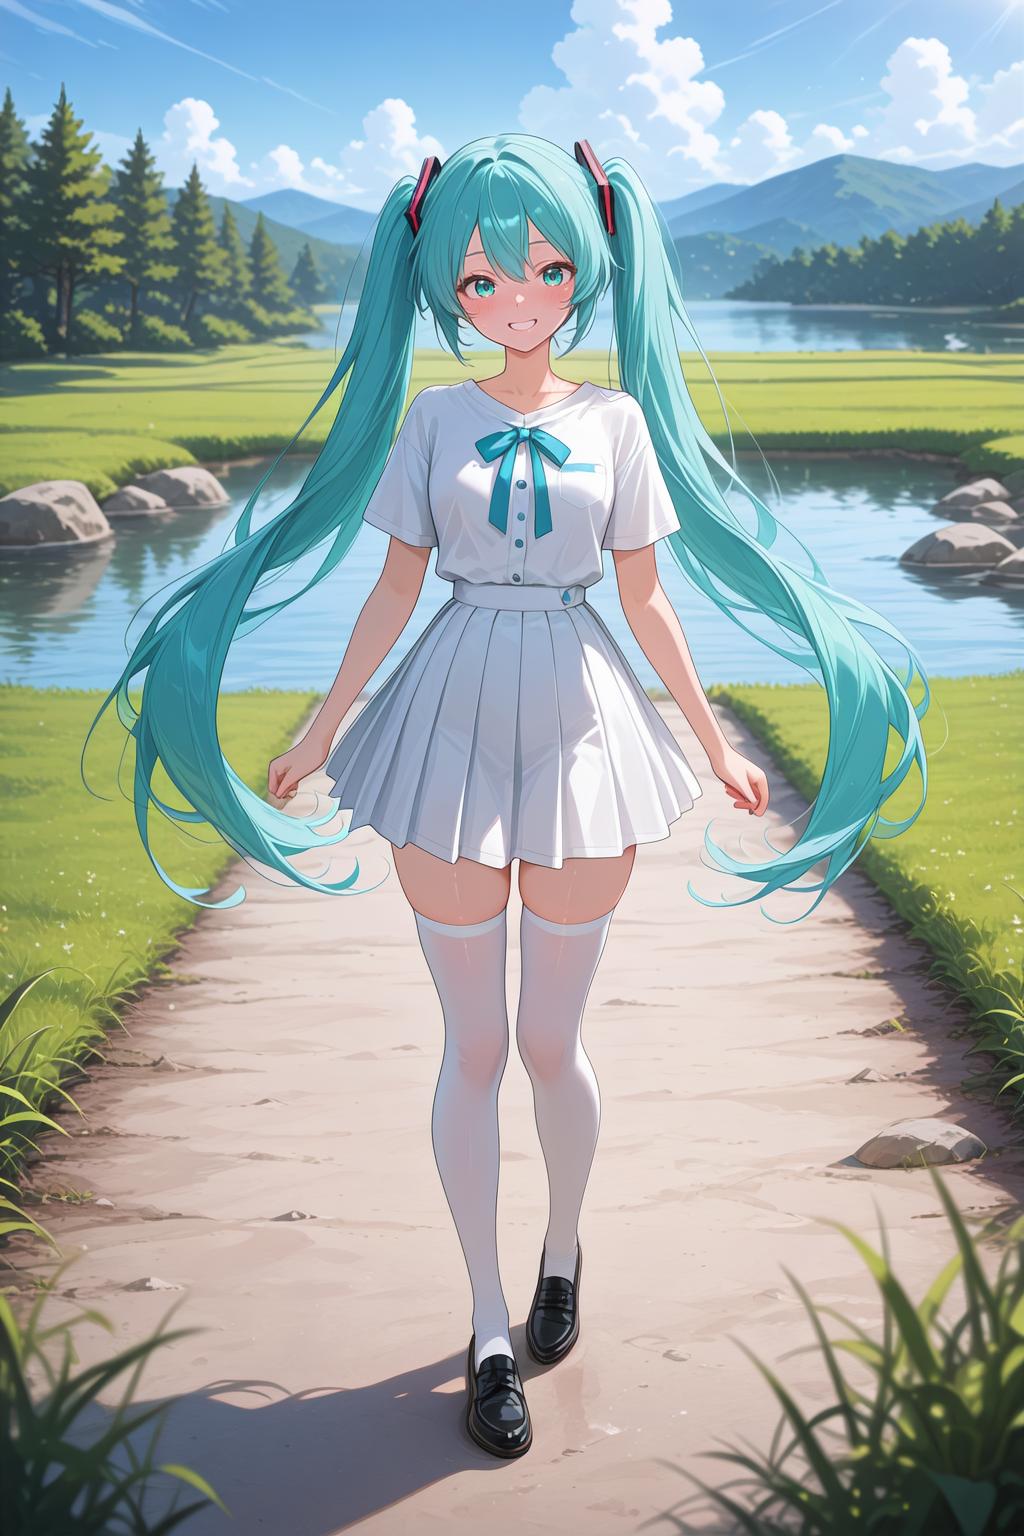

In [37]:
from diffusers_lab.detailer import SDXLDetailer

def detail_face():
    global detailed
    face_detailer = SDXLDetailer(pipeline, "face, eyes")
    detailed = face_detailer(image, pos, neg,
        force_patch_ratio=1, merge_mask=True, preview_mask=True)

detail_face()
detailed

#### Hand Detailer

Detailer: Segmenting using prompt 'hands'
Detailer: Segmented 0.80029296875 @ [710.5, 746.0, 769.5, 817.5]
Detailer: Segmented 0.78515625 @ [268.0, 732.5, 331.5, 802.0]
Detailer: Segmented 2 masks


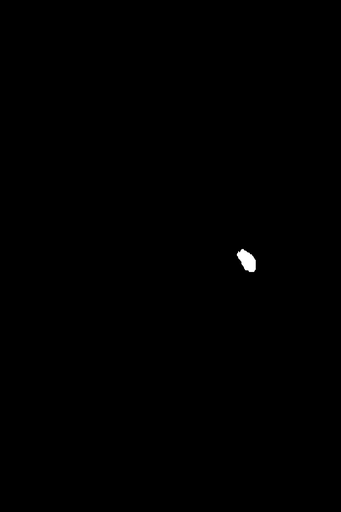

Detailer: Processing mask with bbox [711.0, 747.0, 767.0, 815.0]
Detailer: Expanded context bbox to (683, 713, 795, 849)
Detailer: Force ratio 1, final bbox: (683, 725, 795, 837)
Detailer: Upscaled dimension: (1024, 1024)
Detailer: 64-div Crop: (0, 0, 1024, 1024), size: 
Detailer: Diffusion dimensions: (1024, 1024)
Detailer: Final patch bbox: (683, 725, 795, 837)


  0%|          | 0/8 [00:00<?, ?it/s]

Detailer: Finished mask with bbox (683, 725, 795, 837)


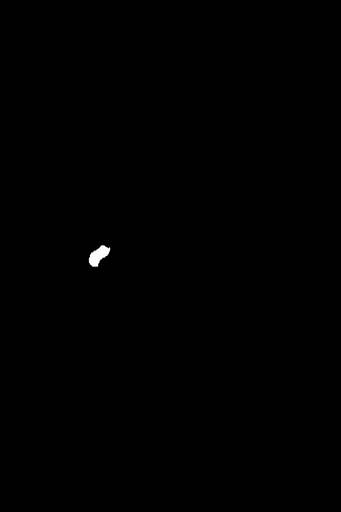

Detailer: Processing mask with bbox [267.0, 736.0, 330.0, 799.0]
Detailer: Expanded context bbox to (236, 705, 361, 830)
Detailer: Force ratio 1, final bbox: (236, 705, 361, 830)
Detailer: Upscaled dimension: (1024, 1024)
Detailer: 64-div Crop: (0, 0, 1024, 1024), size: 
Detailer: Diffusion dimensions: (1024, 1024)
Detailer: Final patch bbox: (236, 705, 361, 830)


  0%|          | 0/8 [00:00<?, ?it/s]

Detailer: Finished mask with bbox (236, 705, 361, 830)


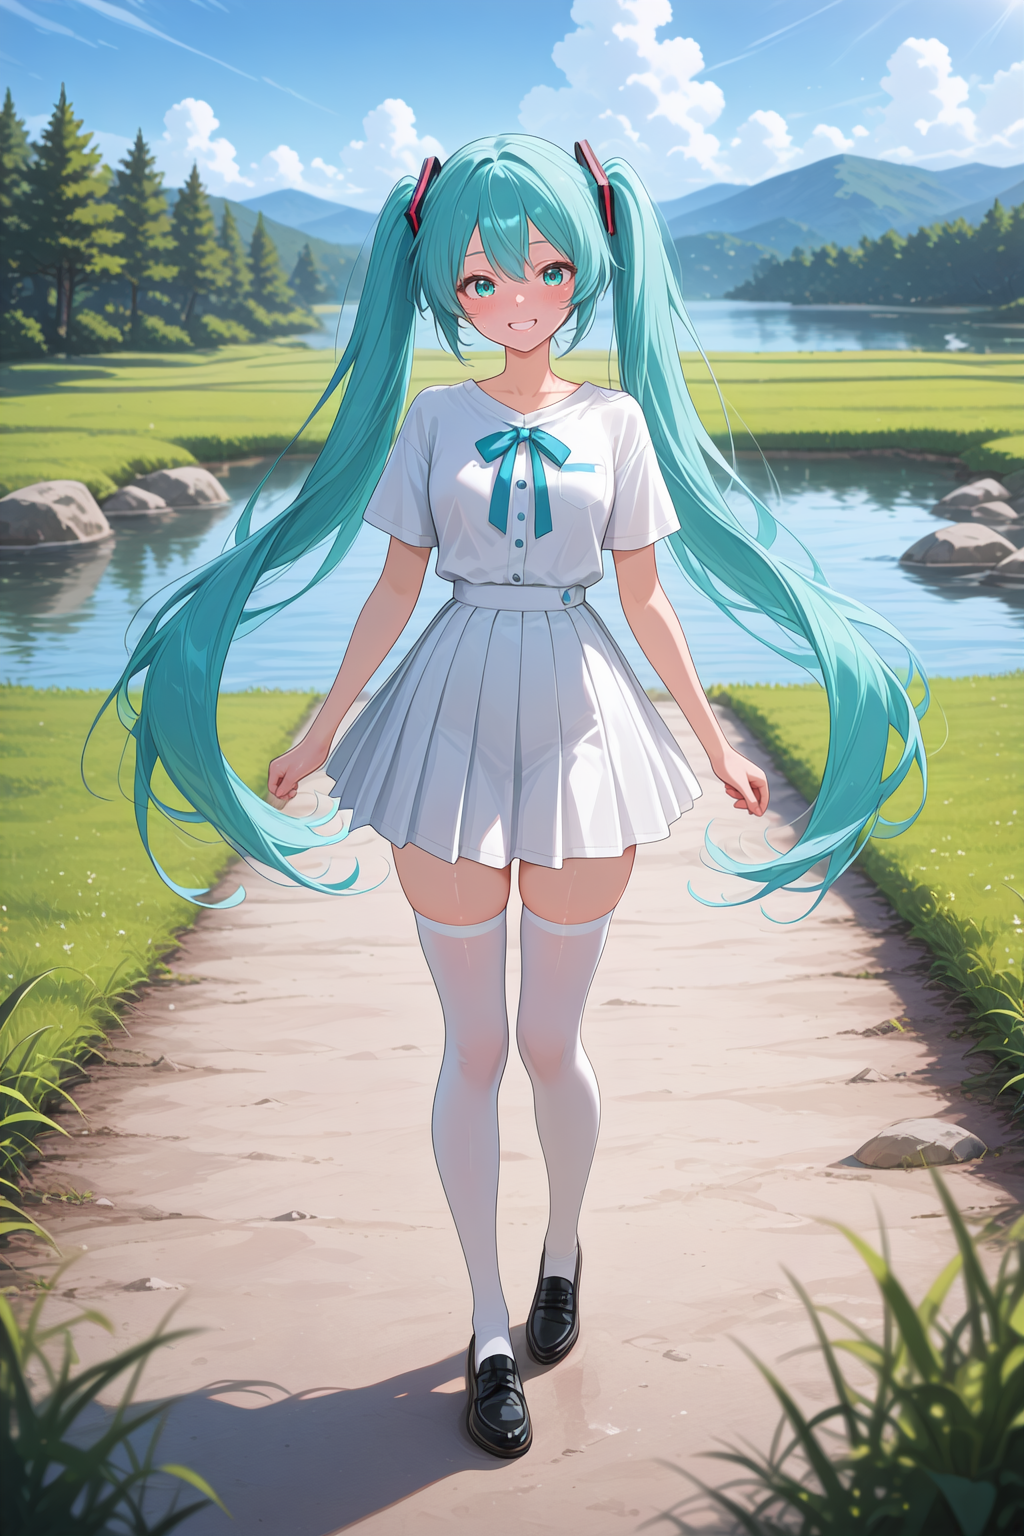

In [38]:
def detail_hand():
    global detailed
    hand_detailer = SDXLDetailer(pipeline, "hands")
    detailed = hand_detailer(detailed, pos, neg,
        context_ratio=0.5, force_patch_ratio=1, preview_mask=True)

detail_hand()
detailed

#### Other Detailers

Detailer: Segmenting using prompt 'shoe'
Detailer: Segmented 0.9482421875 @ [525.5, 1244.0, 581.5, 1364.0]
Detailer: Segmented 0.9453125 @ [465.0, 1336.0, 532.5, 1458.0]
Detailer: Segmented 2 masks
Detailer: Merging all masks


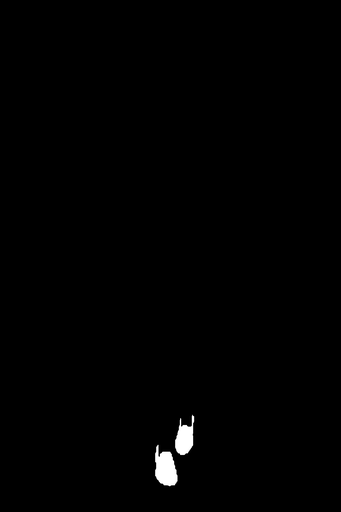

Detailer: Processing mask with bbox [466.0, 1244.0, 582.0, 1458.0]
Detailer: Expanded context bbox to (437, 1191, 611, 1511)
Detailer: Upscaled dimension: (556, 1024)
Detailer: 64-div Crop: (22, 0, 534, 1024), size: 
Detailer: Diffusion dimensions: (512, 1024)
Detailer: Final patch bbox: (443, 1191, 603, 1511)


  0%|          | 0/8 [00:00<?, ?it/s]

Detailer: Finished mask with bbox (437, 1191, 611, 1511)


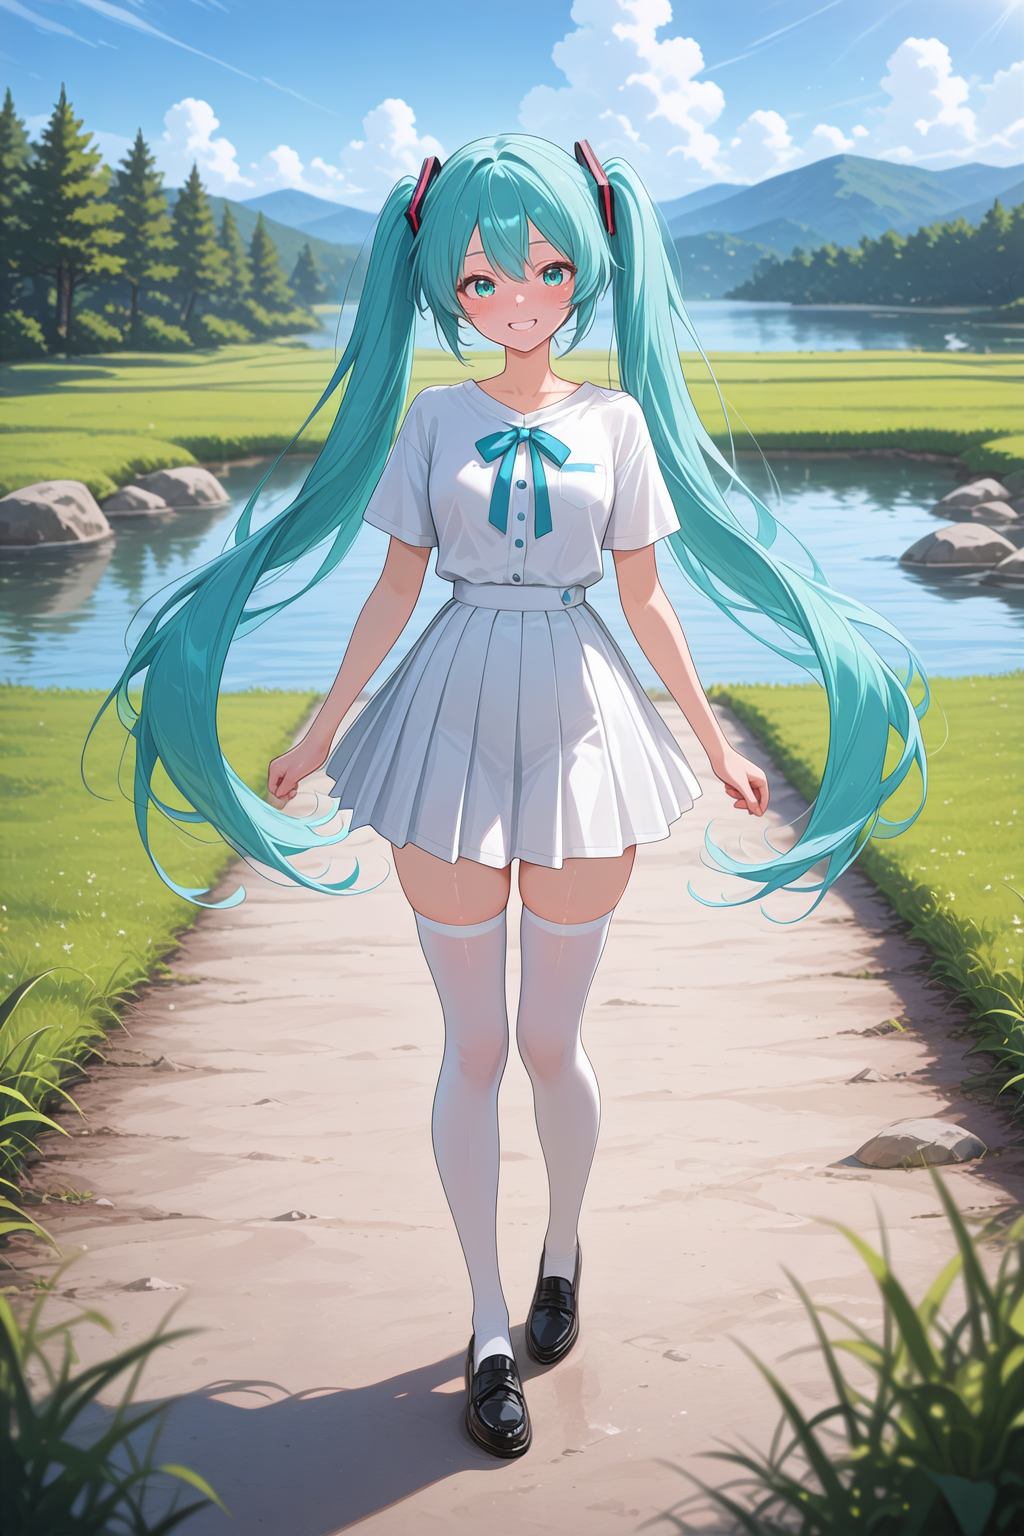

In [39]:
def detail_others():
    global detailed
    detailer = SDXLDetailer(pipeline, "shoe")
    detailed = detailer(detailed, pos, neg,
        merge_mask=True, preview_mask=True)

detail_others()
detailed

### Batch

('masterpiece, best quality, amazing quality, 4k, very aesthetic, high resolution, ultra-detailed, absurdres, newest, scenery, 1girl, solo, full body, standing, straight on, clothed, safe, looking at viewer, smiling, hatsune miku, white shirt, short sleeves, white skirt, pleated skirt, white thighhighs, outdoors, cloud, sky, daytime, wild, grass, lake, black shoes, BREAK, depth of field',
 '1girl, solo, full body, standing, straight on, clothed, safe, looking at viewer, smiling, hatsune miku, white shirt, short sleeves, white skirt, pleated skirt, white thighhighs, outdoors, cloud, sky, daytime, wild, grass, lake, black shoes, monochrome, modern, recent, old, oldest, cartoon, graphic, text, painting, crayon, graphite, abstract, glitch, deformed, mutated, ugly, disfigured, long body, lowres, bad anatomy, (bad hands, missing fingers, extra fingers, extra digits, fewer digits:1.2), cropped, very displeasing, (worst quality, bad quality:1.2), sketch, jpeg artifacts, signature, watermark, u

Seed: 7355045800834264


  0%|          | 0/20 [00:00<?, ?it/s]

/work/ml-lab/diffusers-lab/.venv/lib/python3.13/site-packages/diffusers/pipelines/stable_diffusion_xl/pipeline_stable_diffusion_xl.py:748: FutureWarning: `upcast_vae` is deprecated and will be removed in version 1.0.0. `upcast_vae` is deprecated. Please use `pipe.vae.to(torch.float32)`. For more details, please refer to: https://github.com/huggingface/diffusers/pull/12619#issue-3606633695.
  deprecate(


Detailer: Segmenting using prompt 'face, eyes'
Detailer: Segmented 0.76123046875 @ [467.25, 253.875, 579.5, 370.0]
Detailer: Segmented 0.5390625 @ [469.25, 285.25, 577.5, 324.5]
Detailer: Segmented 2 masks
Detailer: Merging all masks


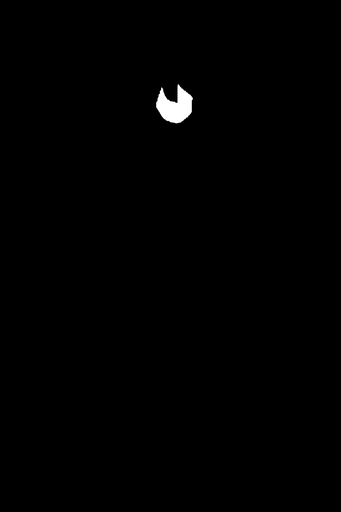

Detailer: Processing mask with bbox [469.0, 252.0, 578.0, 369.0]
Detailer: Expanded context bbox to (442, 223, 605, 398)
Detailer: Force ratio 1, final bbox: (442, 229, 605, 392)
Detailer: Upscaled dimension: (1024, 1024)
Detailer: 64-div Crop: (0, 0, 1024, 1024), size: 
Detailer: Diffusion dimensions: (1024, 1024)
Detailer: Final patch bbox: (442, 229, 605, 392)


  0%|          | 0/8 [00:00<?, ?it/s]

/work/ml-lab/diffusers-lab/.venv/lib/python3.13/site-packages/diffusers/pipelines/stable_diffusion_xl/pipeline_stable_diffusion_xl_inpaint.py:1001: FutureWarning: `upcast_vae` is deprecated and will be removed in version 1.0.0. `upcast_vae` is deprecated. Please use `pipe.vae.to(torch.float32)`. For more details, please refer to: https://github.com/huggingface/diffusers/pull/12619#issue-3606633695.
  deprecate(


Detailer: Finished mask with bbox (442, 229, 605, 392)
Detailer: Segmenting using prompt 'hands'
Detailer: Segmented 0.7685546875 @ [660.5, 785.0, 699.5, 859.0]
Detailer: Segmented 0.72607421875 @ [318.0, 784.5, 356.0, 837.0]
Detailer: Segmented 2 masks


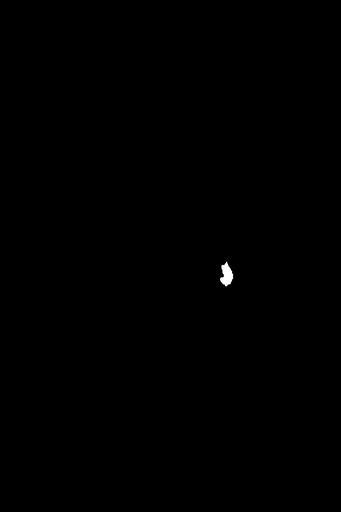

Detailer: Processing mask with bbox [661.0, 785.0, 699.0, 858.0]
Detailer: Expanded context bbox to (642, 749, 718, 894)
Detailer: Force ratio 1, final bbox: (642, 783, 718, 859)
Detailer: Upscaled dimension: (1024, 1024)
Detailer: 64-div Crop: (0, 0, 1024, 1024), size: 
Detailer: Diffusion dimensions: (1024, 1024)
Detailer: Final patch bbox: (642, 783, 718, 859)


  0%|          | 0/8 [00:00<?, ?it/s]

Detailer: Finished mask with bbox (642, 783, 718, 859)


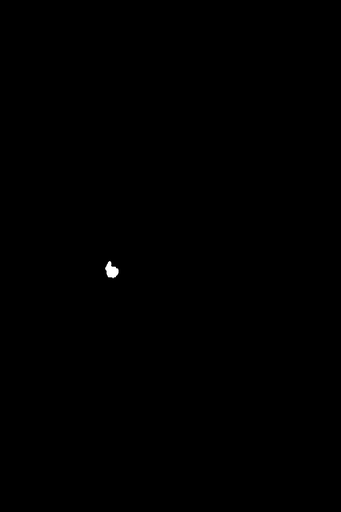

Detailer: Processing mask with bbox [316.0, 783.0, 355.0, 835.0]
Detailer: Expanded context bbox to (297, 757, 374, 861)
Detailer: Force ratio 1, final bbox: (297, 771, 374, 848)
Detailer: Upscaled dimension: (1024, 1024)
Detailer: 64-div Crop: (0, 0, 1024, 1024), size: 
Detailer: Diffusion dimensions: (1024, 1024)
Detailer: Final patch bbox: (297, 771, 374, 848)


  0%|          | 0/8 [00:00<?, ?it/s]

Detailer: Finished mask with bbox (297, 771, 374, 848)
Detailer: Segmenting using prompt 'shoe'
Detailer: Segmented 0.9384765625 @ [480.75, 1319.0, 539.5, 1412.0]
Detailer: Segmented 0.94287109375 @ [528.5, 1250.0, 576.5, 1368.0]
Detailer: Segmented 2 masks
Detailer: Merging all masks


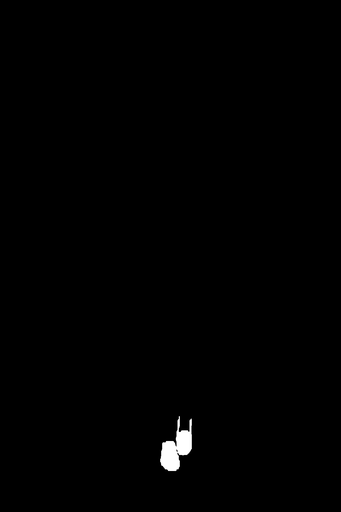

Detailer: Processing mask with bbox [481.0, 1248.0, 575.0, 1412.0]
Detailer: Expanded context bbox to (458, 1207, 598, 1453)
Detailer: Upscaled dimension: (582, 1024)
Detailer: 64-div Crop: (3, 0, 579, 1024), size: 
Detailer: Diffusion dimensions: (576, 1024)
Detailer: Final patch bbox: (458, 1207, 596, 1452)


  0%|          | 0/8 [00:00<?, ?it/s]

Detailer: Finished mask with bbox (458, 1207, 598, 1453)
Saving to /work/outputs/1769081517-7355045800834264.png


('masterpiece, best quality, amazing quality, 4k, very aesthetic, high resolution, ultra-detailed, absurdres, newest, scenery, 1girl, solo, full body, standing, straight on, clothed, safe, looking at viewer, smiling, hatsune miku, white shirt, short sleeves, white skirt, pleated skirt, white thighhighs, outdoors, cloud, sky, daytime, wild, grass, lake, black shoes, BREAK, depth of field',
 '1girl, solo, full body, standing, straight on, clothed, safe, looking at viewer, smiling, hatsune miku, white shirt, short sleeves, white skirt, pleated skirt, white thighhighs, outdoors, cloud, sky, daytime, wild, grass, lake, black shoes, monochrome, modern, recent, old, oldest, cartoon, graphic, text, painting, crayon, graphite, abstract, glitch, deformed, mutated, ugly, disfigured, long body, lowres, bad anatomy, (bad hands, missing fingers, extra fingers, extra digits, fewer digits:1.2), cropped, very displeasing, (worst quality, bad quality:1.2), sketch, jpeg artifacts, signature, watermark, u

Seed: 7270153317963604


  0%|          | 0/20 [00:00<?, ?it/s]

Detailer: Segmenting using prompt 'face, eyes'
Detailer: Segmented 0.77880859375 @ [463.5, 245.5, 579.5, 367.75]
Detailer: Segmented 1 masks
Detailer: Merging all masks


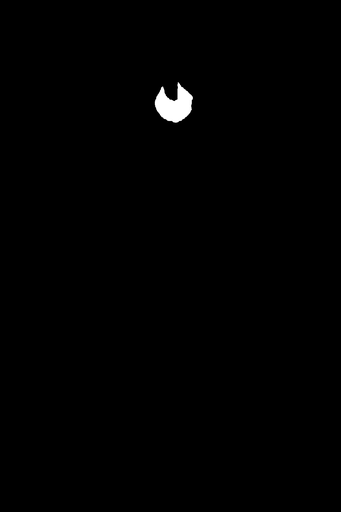

Detailer: Processing mask with bbox [465.0, 246.0, 578.0, 367.0]
Detailer: Expanded context bbox to (437, 216, 606, 397)
Detailer: Force ratio 1, final bbox: (437, 222, 606, 391)
Detailer: Upscaled dimension: (1024, 1024)
Detailer: 64-div Crop: (0, 0, 1024, 1024), size: 
Detailer: Diffusion dimensions: (1024, 1024)
Detailer: Final patch bbox: (437, 222, 606, 391)


  0%|          | 0/8 [00:00<?, ?it/s]

Detailer: Finished mask with bbox (437, 222, 606, 391)
Detailer: Segmenting using prompt 'hands'
Detailer: Segmented 0.77685546875 @ [671.5, 764.0, 720.5, 832.0]
Detailer: Segmented 0.75439453125 @ [280.75, 709.0, 336.25, 786.0]
Detailer: Segmented 2 masks


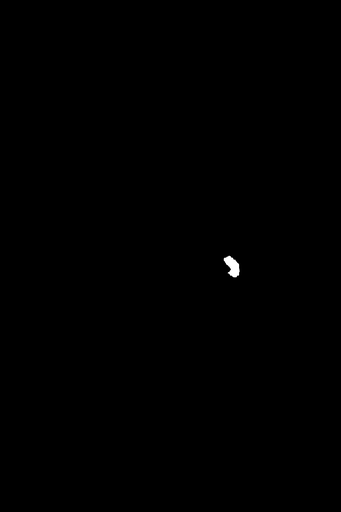

Detailer: Processing mask with bbox [672.0, 767.0, 719.0, 831.0]
Detailer: Expanded context bbox to (649, 735, 742, 863)
Detailer: Force ratio 1, final bbox: (649, 753, 742, 846)
Detailer: Upscaled dimension: (1024, 1024)
Detailer: 64-div Crop: (0, 0, 1024, 1024), size: 
Detailer: Diffusion dimensions: (1024, 1024)
Detailer: Final patch bbox: (649, 753, 741, 845)


  0%|          | 0/8 [00:00<?, ?it/s]

Detailer: Finished mask with bbox (649, 753, 742, 846)


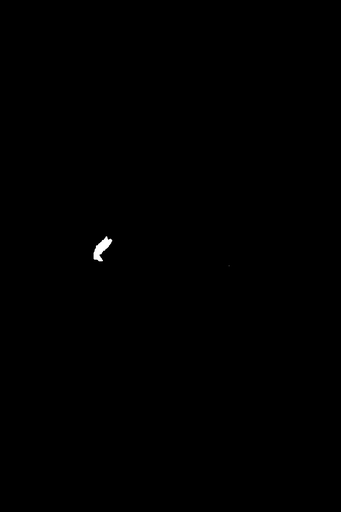

Detailer: Processing mask with bbox [281.0, 709.0, 688.0, 797.0]
Detailer: Expanded context bbox to (78, 665, 891, 841)
Detailer: Force ratio 1, final bbox: (396, 665, 572, 841)
Detailer: Upscaled dimension: (1024, 1024)
Detailer: 64-div Crop: (0, 0, 1024, 1024), size: 
Detailer: Diffusion dimensions: (1024, 1024)
Detailer: Final patch bbox: (396, 665, 572, 841)


  0%|          | 0/8 [00:00<?, ?it/s]

Detailer: Finished mask with bbox (396, 665, 572, 841)
Detailer: Segmenting using prompt 'shoe'
Detailer: Segmented 0.9580078125 @ [565.0, 1289.0, 630.0, 1432.0]
Detailer: Segmented 0.943359375 @ [455.0, 1343.0, 521.5, 1447.0]
Detailer: Segmented 2 masks
Detailer: Merging all masks


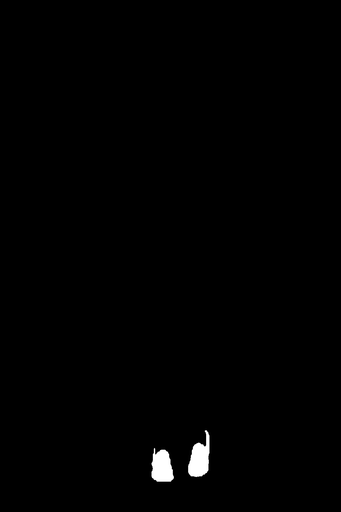

Detailer: Processing mask with bbox [455.0, 1291.0, 628.0, 1444.0]
Detailer: Expanded context bbox to (412, 1253, 671, 1482)
Detailer: Upscaled dimension: (1024, 905)
Detailer: 64-div Crop: (0, 4, 1024, 900), size: 
Detailer: Diffusion dimensions: (1024, 896)
Detailer: Final patch bbox: (412, 1254, 671, 1480)


  0%|          | 0/8 [00:00<?, ?it/s]

Detailer: Finished mask with bbox (412, 1253, 671, 1482)
Saving to /work/outputs/1769081618-7270153317963604.png


('masterpiece, best quality, amazing quality, 4k, very aesthetic, high resolution, ultra-detailed, absurdres, newest, scenery, 1girl, solo, full body, standing, straight on, clothed, safe, looking at viewer, smiling, hatsune miku, white shirt, short sleeves, white skirt, pleated skirt, white thighhighs, outdoors, cloud, sky, daytime, wild, grass, lake, black shoes, BREAK, depth of field',
 '1girl, solo, full body, standing, straight on, clothed, safe, looking at viewer, smiling, hatsune miku, white shirt, short sleeves, white skirt, pleated skirt, white thighhighs, outdoors, cloud, sky, daytime, wild, grass, lake, black shoes, monochrome, modern, recent, old, oldest, cartoon, graphic, text, painting, crayon, graphite, abstract, glitch, deformed, mutated, ugly, disfigured, long body, lowres, bad anatomy, (bad hands, missing fingers, extra fingers, extra digits, fewer digits:1.2), cropped, very displeasing, (worst quality, bad quality:1.2), sketch, jpeg artifacts, signature, watermark, u

Seed: 6897270872950772


  0%|          | 0/20 [00:00<?, ?it/s]

Detailer: Segmenting using prompt 'face, eyes'
Detailer: Segmented 0.76904296875 @ [454.0, 287.0, 562.0, 399.0]
Detailer: Segmented 0.5732421875 @ [456.5, 321.5, 557.0, 354.5]
Detailer: Segmented 2 masks
Detailer: Merging all masks


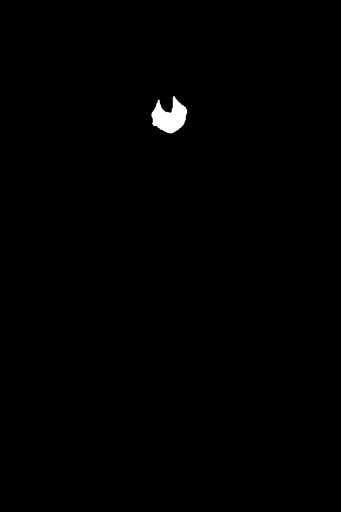

Detailer: Processing mask with bbox [455.0, 289.0, 561.0, 399.0]
Detailer: Expanded context bbox to (429, 262, 587, 426)
Detailer: Force ratio 1, final bbox: (429, 265, 587, 423)
Detailer: Upscaled dimension: (1024, 1024)
Detailer: 64-div Crop: (0, 0, 1024, 1024), size: 
Detailer: Diffusion dimensions: (1024, 1024)
Detailer: Final patch bbox: (429, 265, 587, 423)


  0%|          | 0/8 [00:00<?, ?it/s]

Detailer: Finished mask with bbox (429, 265, 587, 423)
Detailer: Segmenting using prompt 'hands'
Detailer: Segmented 0.76220703125 @ [691.0, 693.5, 749.0, 749.5]
Detailer: Segmented 0.76611328125 @ [277.5, 697.0, 336.5, 756.0]
Detailer: Segmented 2 masks


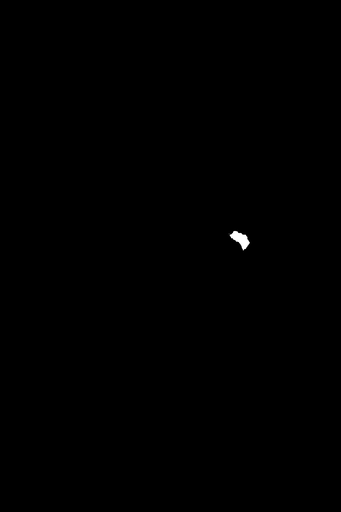

Detailer: Processing mask with bbox [687.0, 693.0, 749.0, 751.0]
Detailer: Expanded context bbox to (656, 664, 780, 780)
Detailer: Force ratio 1, final bbox: (660, 664, 776, 780)
Detailer: Upscaled dimension: (1024, 1024)
Detailer: 64-div Crop: (0, 0, 1024, 1024), size: 
Detailer: Diffusion dimensions: (1024, 1024)
Detailer: Final patch bbox: (660, 664, 776, 780)


In [ ]:
import time
def run():
    run_t2i()
    detail_face()
    detail_hand()
    detail_others()

iters = 4
save_path = f"{os.environ.get('DATA_ROOT')}/outputs"
!mkdir -p {save_path}
for i in range(iters):
    run()
    fname = f"{save_path}/{int(time.time())}-{last_seed}.png"
    print(f"Saving to {fname}")
    detailed.save(fname)
